In [5]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray import DataArray
import pandas as pd
# from PyEMD import EEMD
import pylab as plt
from numpy import diff

In [6]:
lat_min, lat_max = (60,76) # Norwegian Sea
lon_min, lon_max = (0,20)
# read heat flux; unit: w/m**2
data = xr.open_dataset('/work/uo1075/u241321/data/ahfs_1970-2019_assi.nc', decode_times=False)
data_l = xr.open_dataset('/work/uo1075/u241321/data/ahfl_1970-2019_assi.nc', decode_times=False)

var = np.mean(data['ahfs'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)), axis=1) + np.mean(data_l['ahfl'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)), axis=1) 

# weight average 
weights = np.cos(np.deg2rad(var.lat))
weights.name = "weights"
air_weighted = var.weighted(weights)
#. horizontally averaged heat flux 
heat_mean = air_weighted.mean(("lon", "lat"))# unit: W/m^2

# read temperature
upper, bottom = (6, 310)
data1       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/temperature_1969-2019_assi_5000.nc",decode_times=False)
var1 = np.mean(data1['thetao'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), depth=slice(upper, bottom)), axis=1)

# read density
data2       = xr.open_dataset("/work/uo1075/u241321/data/rhopoto_1969-2019_assi_absolute.nc",decode_times=False) 
var2 = np.mean(data2['rhopoto'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), depth=slice(upper, bottom)), axis=1)


In [7]:
var1_weighted = var1.weighted(weights)
var2_weighted = var2.weighted(weights)
cp=4000 # J/(kg C)   specific heat capacity of seawater, assue it's constant 
heat = var1_weighted.obj*var2_weighted.obj*cp


# read ocean thickness at each level
thick = xr.open_dataset("/work/uo1075/u241321/data/thickness_regrid.nc") 
thickness1 = thick['ddpo'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
thickness = thickness1[0,0:15,:,:]  # thickness varies slightly spatially, only integrate for 310m, 15 levels

# integrate vertically : * vertical thickness, heat_h*thickness.sum('depth')
heat_sum = np.sum(heat*thickness.values, axis=1) #  This is heat content anomlies, unit: J/m^2


# average horizontally 
# heat_ver1 = heat_ver.weighted(weights)
heat_content = heat_sum.mean(("lon", "lat"))   # J/m^2 


# Tendency of heat content,  namely, using year to year difference
dx = 1
y = heat_content
dy = diff(y)/dx  # unit: J/m^2*year


heat_mean_y = heat_mean*365*24*3600 # convert the unit to J/m^2*year
# Ocean contribution
ocean = dy - heat_mean_y[0:49]   # unit: W/m^2

/tmp/ipykernel_1061188/1266930271.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, dy, '-', linestyle='solid', color='black', linewidth=5, markersize=10, label = 'Tendency of OHC')
/tmp/ipykernel_1061188/1266930271.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, heat_mean_y[0:49], '-', linestyle='solid', color='red', linewidth=5, markersize=10, label = 'Turbulent Heat flux')


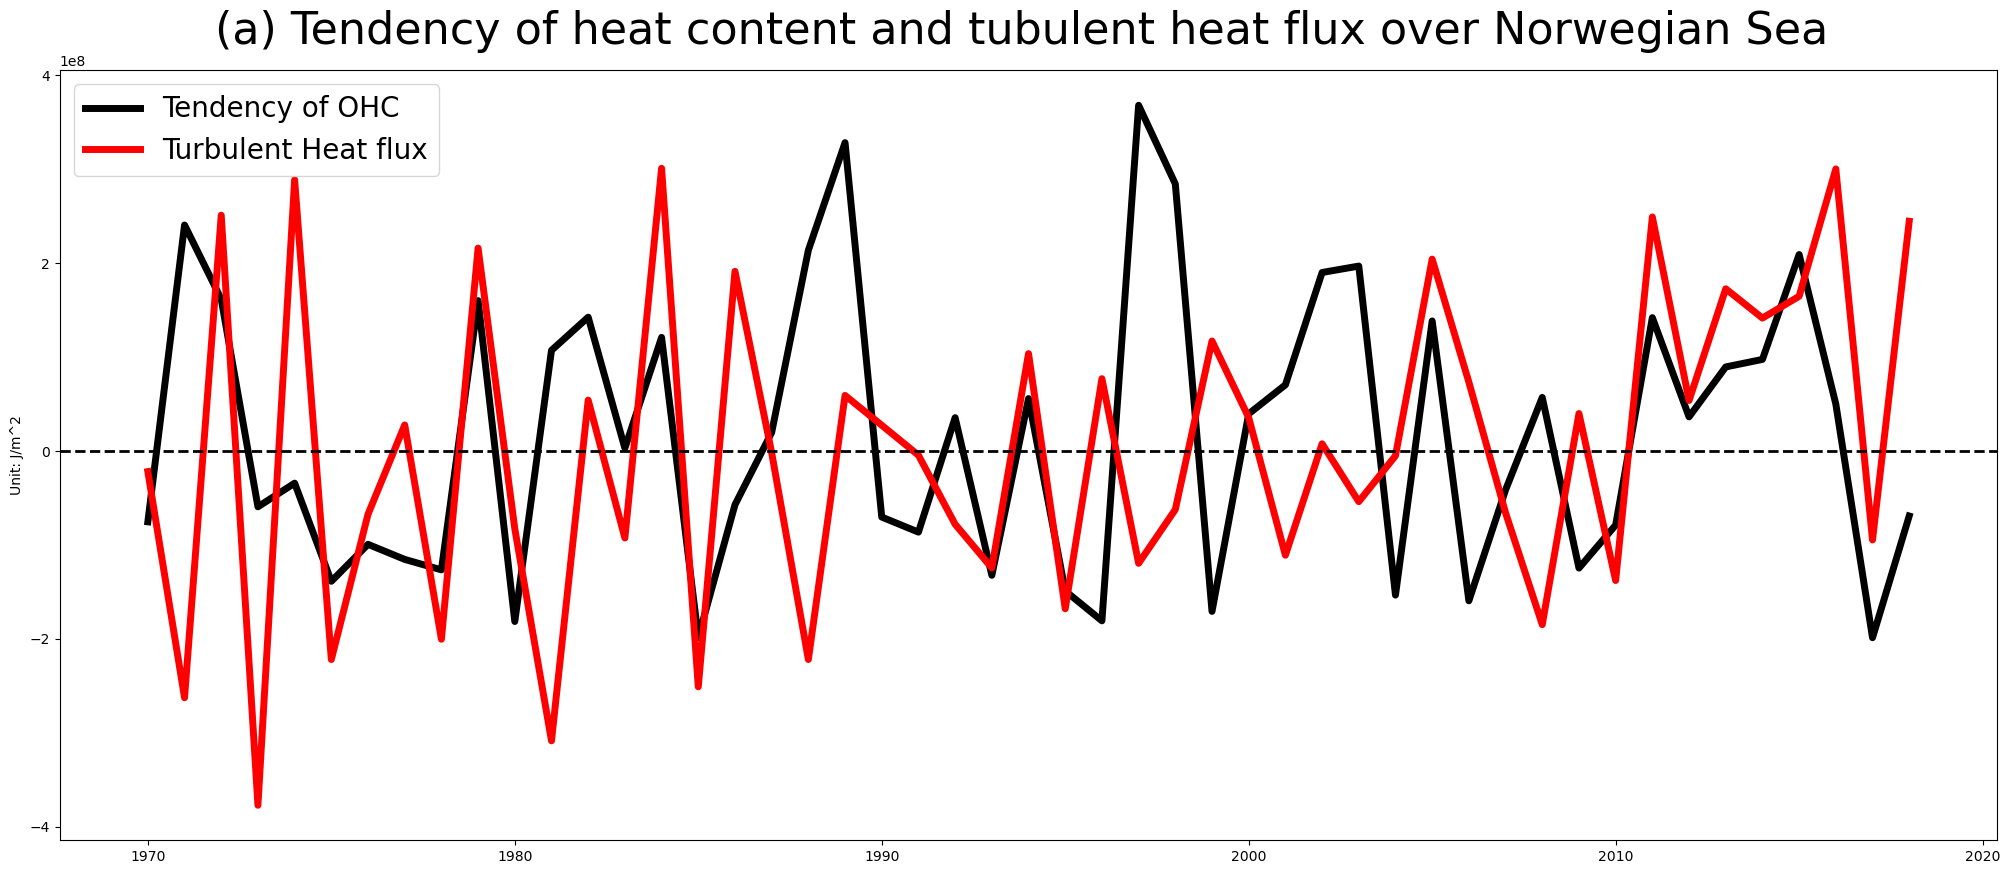

In [8]:


x = np.arange(1970,2019,1)  # starting from difference between 1971 and 1970

fig, ax = plt.subplots(figsize = [25,10])
ax.plot(x, dy, '-', linestyle='solid', color='black', linewidth=5, markersize=10, label = 'Tendency of OHC')
ax.plot(x, heat_mean_y[0:49], '-', linestyle='solid', color='red', linewidth=5, markersize=10, label = 'Turbulent Heat flux')
# ax.plot(x, ocean, '-', linestyle='solid', color='blue', linewidth=5, markersize=10, label = 'Ocean supply')
ax.set(xlabel='', ylabel='Unit: J/m^2',
       title=' ')

ax.set_title('(a) Tendency of heat content and tubulent heat flux over Norwegian Sea ',size = '32', loc = 'center', pad = 19)
ax.legend(loc='upper left', fontsize='20')
ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')

plt.rcParams["font.size"] = "35"
plt.show()
fig.savefig('/work/uo1075/u241321/results/tflux.pdf')


In [6]:
trans_fsc = np.load("/work/uo1075/u241321/data/eemd_htransport310.npy")
trans_ifc = np.load("/work/uo1075/u241321/data/eemd_htransport310_ifc.npy")

transport = trans_fsc[0,:] + trans_ifc[0,:]

In [33]:
ifc-fsc

array([-0.00844974, -0.01629934,  0.03893077,  0.04370876,  0.01936926,
        0.00050515,  0.01639237, -0.01597514,  0.0204978 ,  0.0007251 ,
       -0.00162408, -0.01650714,  0.00760763, -0.02885993, -0.0322908 ,
        0.00115778,  0.00697346,  0.01858403,  0.00306183,  0.01096552,
       -0.0310166 ,  0.00815421,  0.02033029,  0.00913496,  0.00174965,
        0.00131034,  0.00666687, -0.02123556,  0.00012349, -0.0205024 ,
       -0.00454238,  0.00387679,  0.00564436,  0.00864251,  0.02870523,
        0.01414936, -0.02051824, -0.0138009 , -0.05200345, -0.01645109,
        0.01341082,  0.01304256,  0.01319733,  0.03282578,  0.00991801,
       -0.04173766, -0.00220985,  0.04633394, -0.00531238,  0.00841461])

In [7]:
np.corrcoef(transport[0:49], dy)[0,1]

0.16688275586880874

In [8]:
np.corrcoef(heat_mean_y[0:49], dy)[0,1]

0.14698818926923365

/tmp/ipykernel_2881657/2012717371.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, dy, '-', linestyle='solid', color='black', linewidth=5, markersize=10, label = 'Tendency of OHC')
/tmp/ipykernel_2881657/2012717371.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(x, transport[0:49], '-', linestyle='solid', color='blue', linewidth=5, markersize=10, label = 'Heat transport')


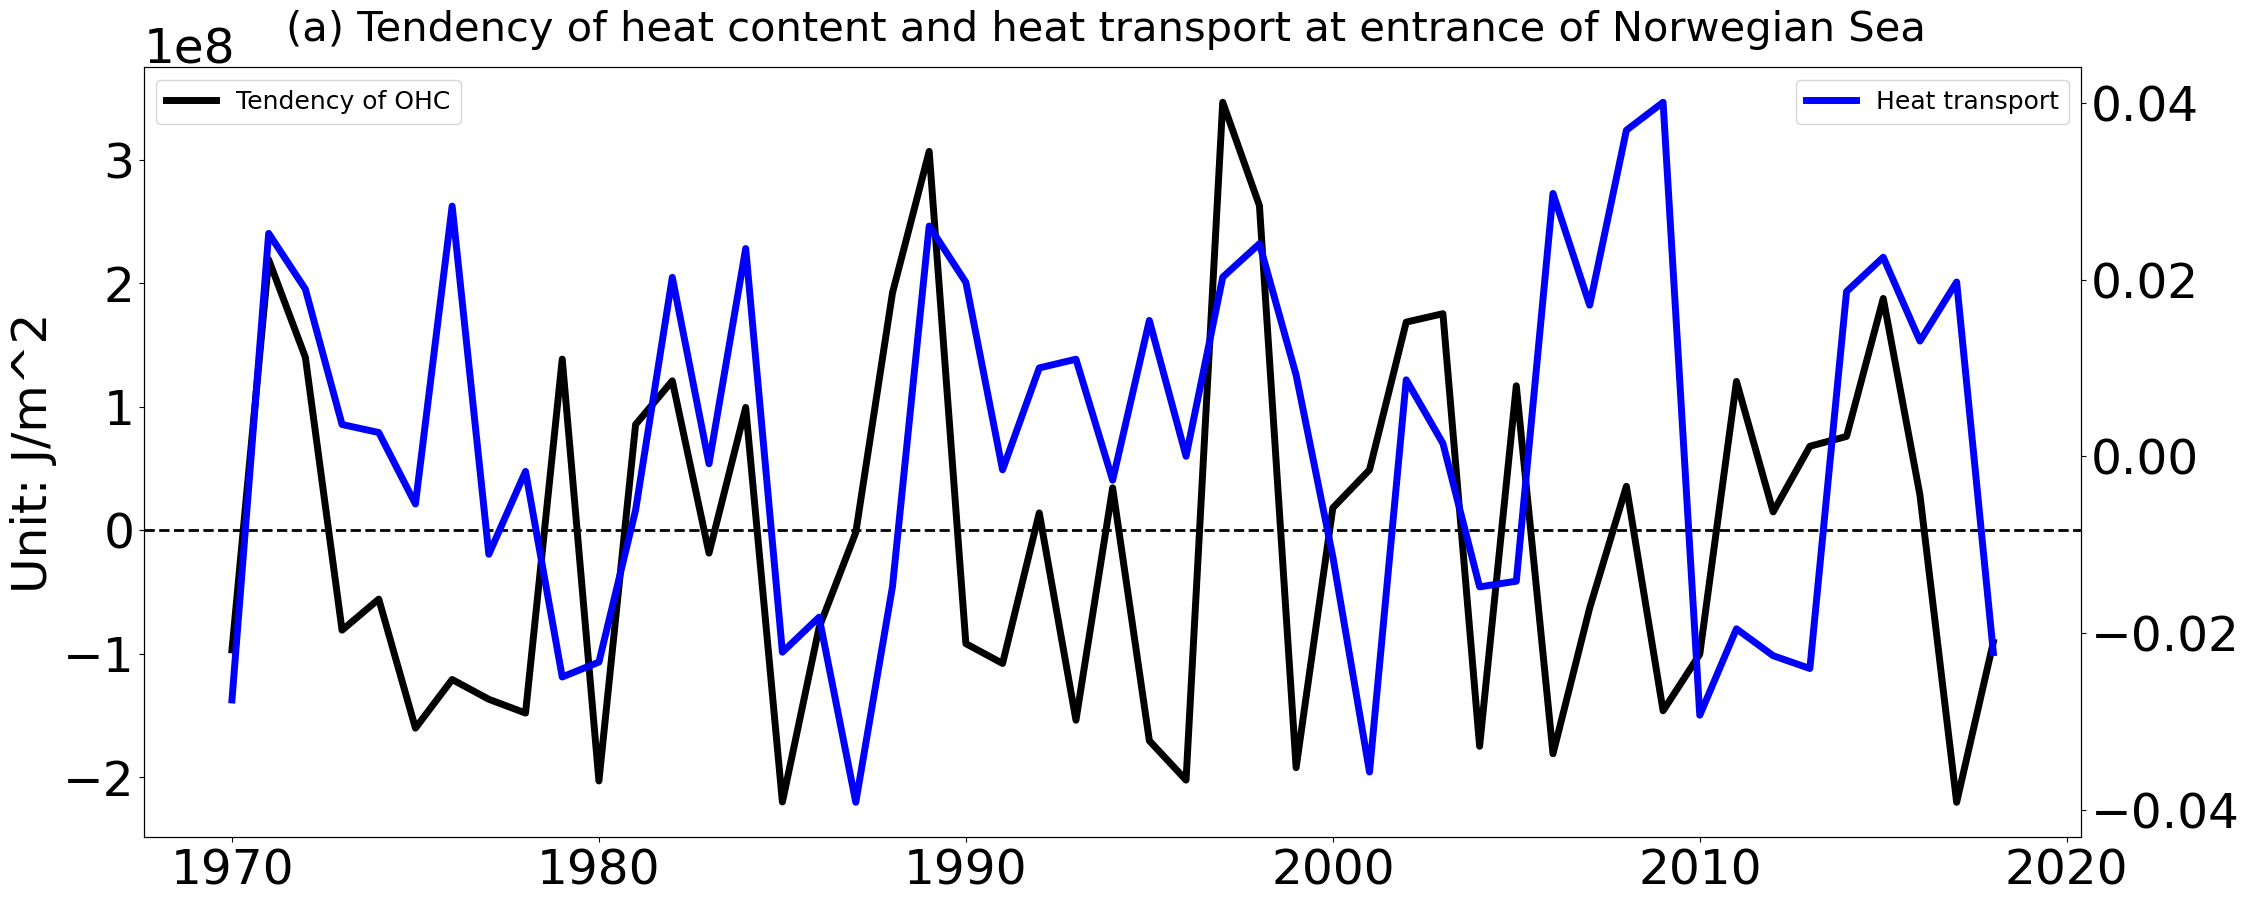

In [9]:


x = np.arange(1970,2019,1)  # starting from difference between 1971 and 1970

fig, ax = plt.subplots(figsize = [25,10])
ax.plot(x, dy, '-', linestyle='solid', color='black', linewidth=5, markersize=10, label = 'Tendency of OHC')
# ax.plot(x, heat_mean_y[0:49], '-', linestyle='solid', color='red', linewidth=5, markersize=10, label = 'Turbulent Heat flux')
# ax.plot(x, ocean, '-', linestyle='solid', color='blue', linewidth=5, markersize=10, label = 'Ocean supply')
ax.set(xlabel='', ylabel='Unit: J/m^2',
       title=' ')

ax.set_title('(a) Tendency of heat content and heat transport at entrance of Norwegian Sea ',size = '30', loc = 'center', pad = 19)
ax.legend(loc='upper left', fontsize='18')
ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')

ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax1.plot(x, transport[0:49], '-', linestyle='solid', color='blue', linewidth=5, markersize=10, label = 'Heat transport')
ax1.legend(loc='upper right', fontsize='18')


# plt.rcParams["font.size"] = "25"
plt.show()
fig.savefig('/work/uo1075/u241321/results/heat_transport.pdf')


In [21]:
heat_budget = np.zeros((3,49))  #  raw input data;  c1-c4
heat_budget [0,:] = dy
heat_budget [1,:] = heat_mean_y[0:49]
heat_budget [2,:] = ocean
np.save("/work/uo1075/u241321/data/slheat_budget_Norw_wt", heat_budget)



In [10]:
np.save("/work/uo1075/u241321/data/slheat_Norw", heat_mean_y)


In [9]:
# lead-lag correlation
from scipy.stats import pearsonr
import numpy as np

# lead lag pearson correlation, negative values indicate data1 leads data2, n is the lead lag step
# the time length for correlation is sample-n; for example, for 50 years sample,
# if 10 yrs leadlag is choosen, the time length is 40 yrs

def leadlagcor(data1,data2,n):
    a=-n
    b=-a
    c=b*2+1
    x=np.arange(-n,n+1,1)
    r=np.zeros((c,1))
    p=np.zeros((c,1))
    begin=x[c-1]
    end=len(data1)-x[c-1]
    
    for i in range(c):
        if i<=(b):
            r[n-i],p[n-i]=pearsonr(data1[:end], data2[i:end+i])
        else:
            r[i],p[i]=pearsonr(data1[x[i]:end+x[i]], data2[:end])
    return r

/tmp/ipykernel_1061188/1367491662.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, heat_mea[0:49], '-', linestyle='solid', color='red', linewidth=5, markersize=10, label = 'Turbulent Heat flux')


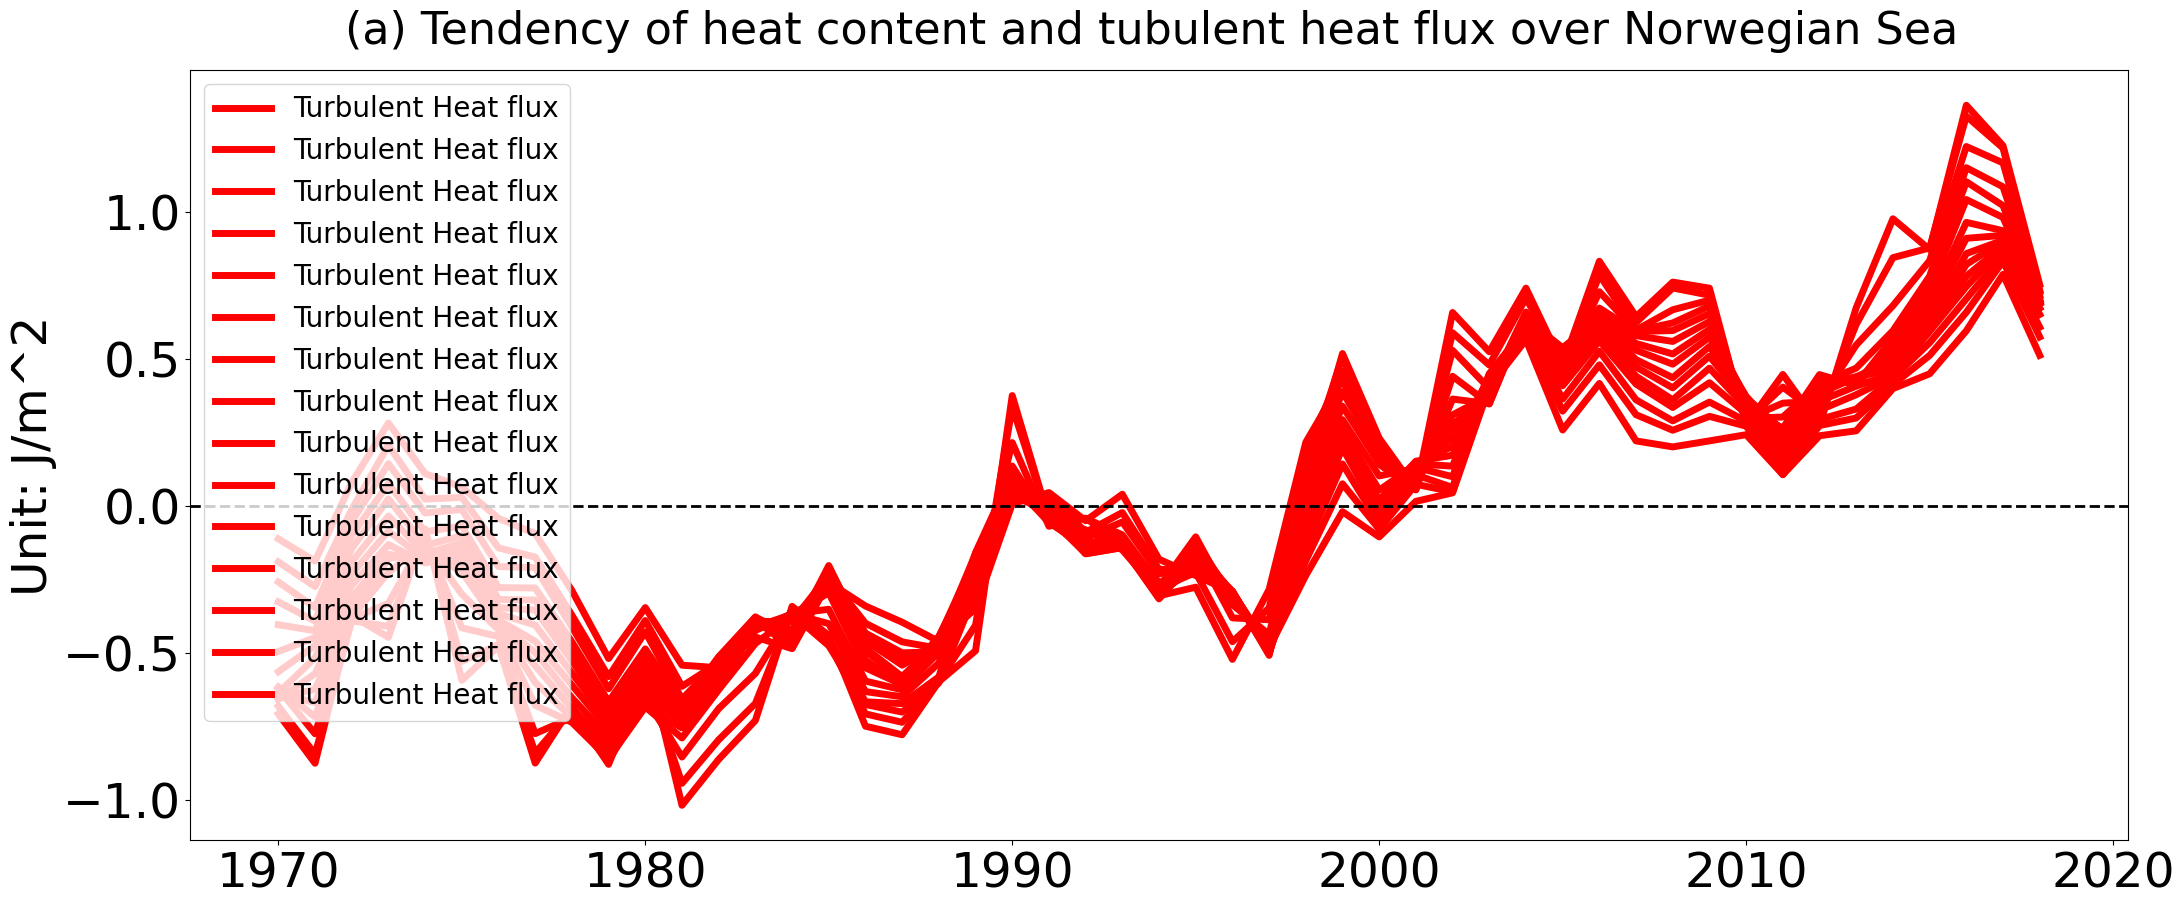

In [19]:
heat_mea = var1_weighted.mean(("lon", "lat"))# unit: W/m^2



x = np.arange(1970,2019,1)  # starting from difference between 1971 and 1970

fig, ax = plt.subplots(figsize = [25,10])
# ax.plot(x, heat, '-', linestyle='solid', color='black', linewidth=5, markersize=10, label = 'Tendency of OHC')
ax.plot(x, heat_mea[0:49], '-', linestyle='solid', color='red', linewidth=5, markersize=10, label = 'Turbulent Heat flux')
# ax.plot(x, ocean, '-', linestyle='solid', color='blue', linewidth=5, markersize=10, label = 'Ocean supply')
ax.set(xlabel='', ylabel='Unit: J/m^2',
       title=' ')

ax.set_title('(a) Tendency of heat content and tubulent heat flux over Norwegian Sea ',size = '32', loc = 'center', pad = 19)
ax.legend(loc='upper left', fontsize='20')
ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')

plt.rcParams["font.size"] = "35"
plt.show()

In [16]:
3.2*365*24*3600

100915200.0

/tmp/ipykernel_1061188/1675701691.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, dy, '-', linestyle='solid', color='black', linewidth=5, markersize=10, label = 'dy')
/tmp/ipykernel_1061188/1675701691.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, y[0:49], '-', linestyle='solid', color='red', linewidth=5, markersize=10, label = 'y')


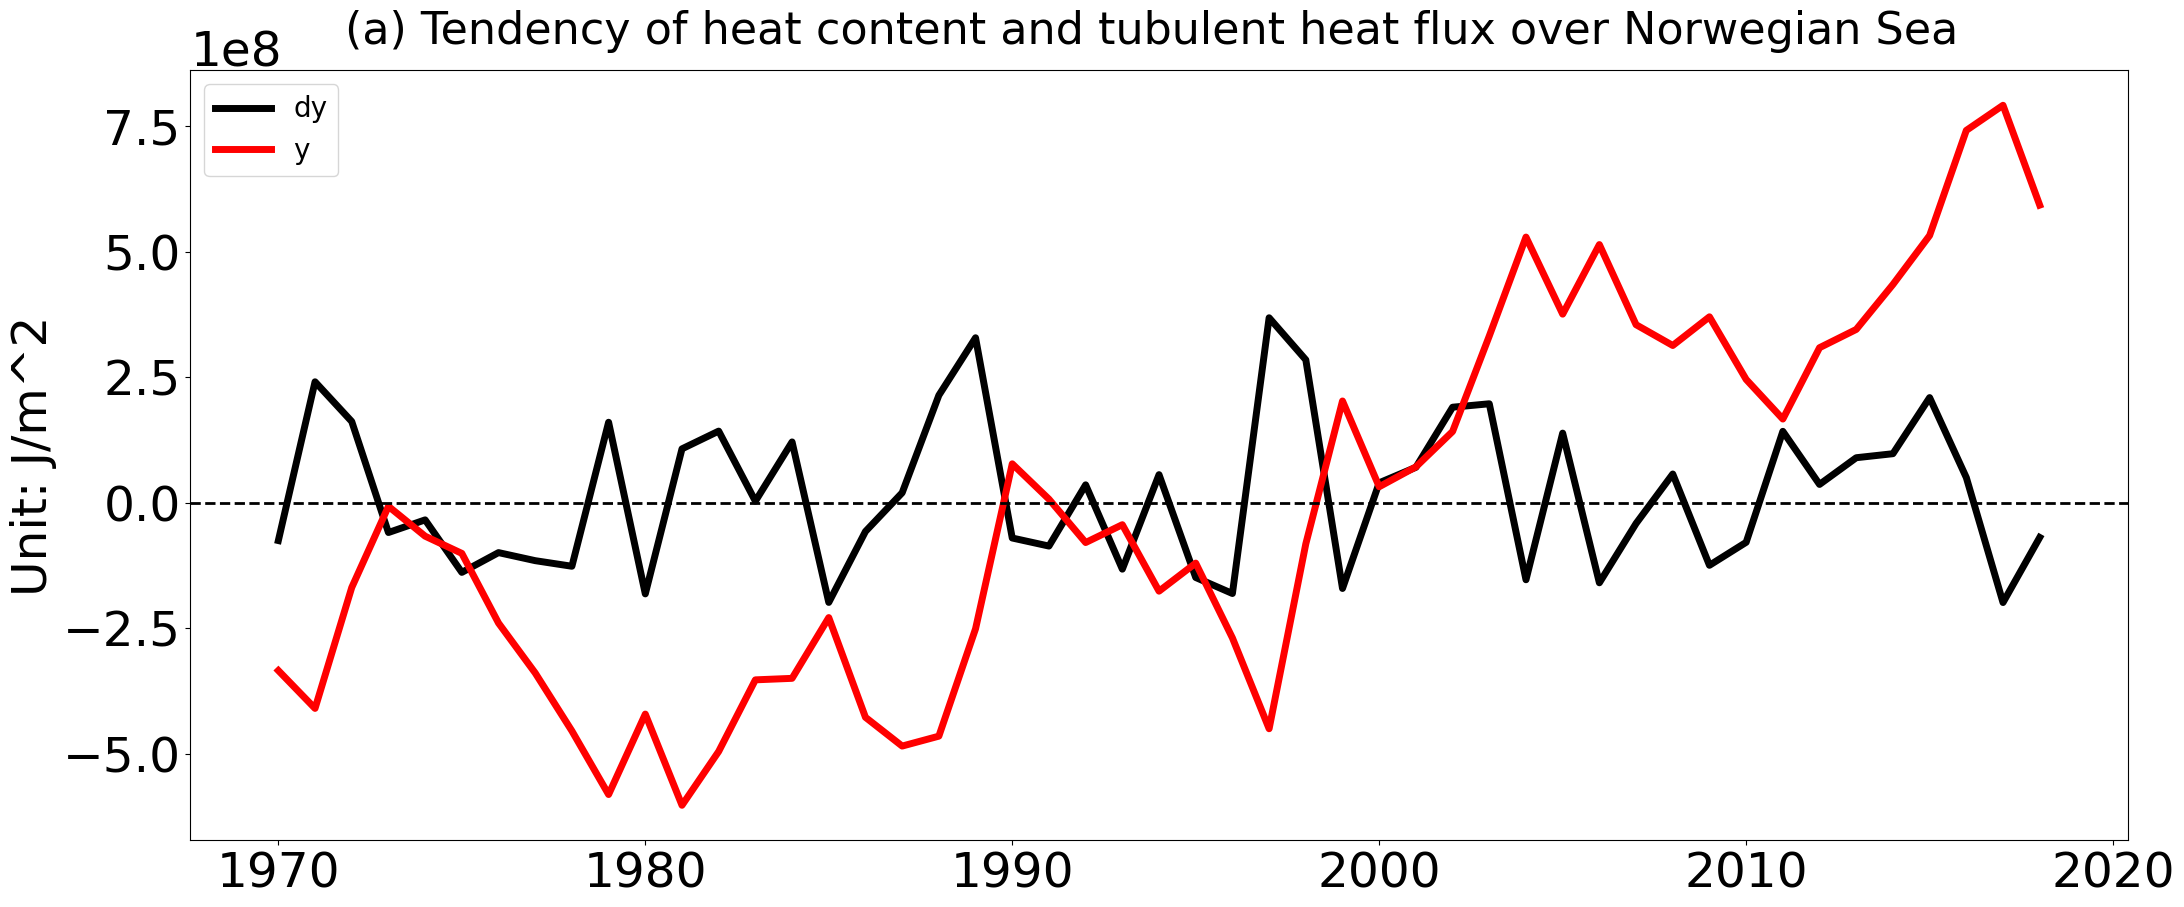

In [20]:
# heat_content = heat_sum.mean(("lon", "lat"))   # J/m^2 

# aaa = thickness.weighted(weights)

# heat_mea = aaa.mean(("lon", "lat"))# unit: W/m^2



x = np.arange(1970,2019,1)  # starting from difference between 1971 and 1970

fig, ax = plt.subplots(figsize = [25,10])
ax.plot(x, dy, '-', linestyle='solid', color='black', linewidth=5, markersize=10, label = 'dy')
ax.plot(x, y[0:49], '-', linestyle='solid', color='red', linewidth=5, markersize=10, label = 'y')
# ax.plot(x, ocean, '-', linestyle='solid', color='blue', linewidth=5, markersize=10, label = 'Ocean supply')
ax.set(xlabel='', ylabel='Unit: J/m^2',
       title=' ')

ax.set_title('(a) Tendency of heat content and tubulent heat flux over Norwegian Sea ',size = '32', loc = 'center', pad = 19)
ax.legend(loc='upper left', fontsize='20')
ax.axhline(0, linewidth=2, color='black', linestyle= 'dashed')

plt.rcParams["font.size"] = "35"
plt.show()